# Kurtosis & Skewness for Mean Reversion by ChatGPT - Strategy - Backtesting 

### Import Library

In [9]:
import warnings
warnings.filterwarnings('ignore')
#
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
#
from scipy.stats import kurtosis, skew


### Load Price Data

In [10]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [11]:
data = dataset.copy()

In [12]:
data = data[data.index > '2020-11-01 00:00:00']
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
# data = data[data.index > '2024-11-01 00:00:00']

In [13]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-25 14:15:00,1358.4,1360.8,1358.2,1360.5,6708
2025-02-25 14:20:00,1360.3,1362.1,1359.4,1361.0,7025
2025-02-25 14:25:00,1361.0,1362.2,1360.8,1361.7,4896


In [14]:
def prepare_data(df):
    period = 30
    df['Returns'] = df['Close'].pct_change()
    df['Kurtosis'] = df['Returns'].rolling(period).apply(kurtosis, raw=True)
    df['Skew'] = df['Returns'].rolling(period).apply(skew, raw=True)

    # Long if skewness is extremely negative and kurtosis is high (oversold)
    df['Long_Signal'] = (df['Skew'] < -1) & (df['Kurtosis'] > 3)
    
    # Short if skewness is extremely positive and kurtosis is high (overbought)
    df['Short_Signal'] = (df['Skew'] > 1) & (df['Kurtosis'] > 3)
    return df

In [15]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [16]:
class MainStrategy(Strategy):
    reward_on_risk = 3
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
            return

        if self.position:
            return 
        long_signal = self.data.Long_Signal[-1]
        short_signal = self.data.Short_Signal[-1]
        close_price = self.data.Close[-1]
        open_price = self.data.Open[-1]
        if long_signal == True:
            buy_price = close_price
            sl = buy_price - 3
            tp = buy_price + 6
            self.buy(size=1, sl=sl, tp=tp)
            # self.buy(size=1, sl=sl, tp=tp, limit=buy_price)
        elif short_signal == True:
            sell_price = close_price
            sl = sell_price + 3
            tp = sell_price - 6
            self.sell(size=1, sl=sl, tp=tp)
            # self.sell(size=1, sl=sl, tp=tp, limit=sell_price)

In [17]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [18]:
stats

Start                     2020-11-02 11:30:00
End                       2025-02-25 14:45:00
Duration                   1576 days 03:15:00
Exposure Time [%]                   11.923224
Equity Final [$]                   1064.43078
Equity Peak [$]                    1521.91465
Return [%]                         -29.037948
Buy & Hold Return [%]                51.42539
Return (Ann.) [%]                   -7.719441
Volatility (Ann.) [%]                4.377551
Sharpe Ratio                        -1.763415
Sortino Ratio                       -1.945926
Calmar Ratio                        -0.256595
Max. Drawdown [%]                  -30.084195
Avg. Drawdown [%]                   -1.914427
Max. Drawdown Duration     1370 days 01:30:00
Avg. Drawdown Duration       78 days 13:52:00
# Trades                                  806
Win Rate [%]                        31.885856
Best Trade [%]                       0.711815
Worst Trade [%]                     -0.692557
Avg. Trade [%]                    

In [19]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,-1,42,70,908.72730,909.0,-0.27270,-0.000300,2020-11-03 10:45:00,2020-11-03 14:30:00,None,0 days 03:45:00
1,-1,76,88,908.02751,911.8,-3.77249,-0.004155,2020-11-04 09:20:00,2020-11-04 10:20:00,None,0 days 01:00:00
2,1,158,167,917.27510,914.1,-3.17510,-0.003461,2020-11-05 13:20:00,2020-11-05 14:05:00,None,0 days 00:45:00
3,1,197,210,908.47246,905.0,-3.47246,-0.003822,2020-11-06 10:55:00,2020-11-06 13:25:00,None,0 days 02:30:00
4,-1,226,239,914.52556,917.6,-3.07444,-0.003362,2020-11-09 09:05:00,2020-11-09 10:10:00,None,0 days 01:05:00
...,...,...,...,...,...,...,...,...,...,...,...
801,1,38123,38135,1050.51506,1046.8,-3.71506,-0.003536,2023-10-31 11:05:00,2023-10-31 13:30:00,None,0 days 02:25:00
802,-1,38177,38184,1047.98551,1042.4,5.58551,0.005330,2023-11-01 11:20:00,2023-11-01 13:20:00,None,0 days 02:00:00
803,-1,38201,38216,1056.68290,1060.0,-3.31710,-0.003139,2023-11-02 09:05:00,2023-11-02 10:20:00,None,0 days 01:15:00
804,-1,38217,38218,1059.88194,1063.2,-3.31806,-0.003131,2023-11-02 10:25:00,2023-11-02 10:30:00,None,0 days 00:05:00


In [20]:
# bt.plot()

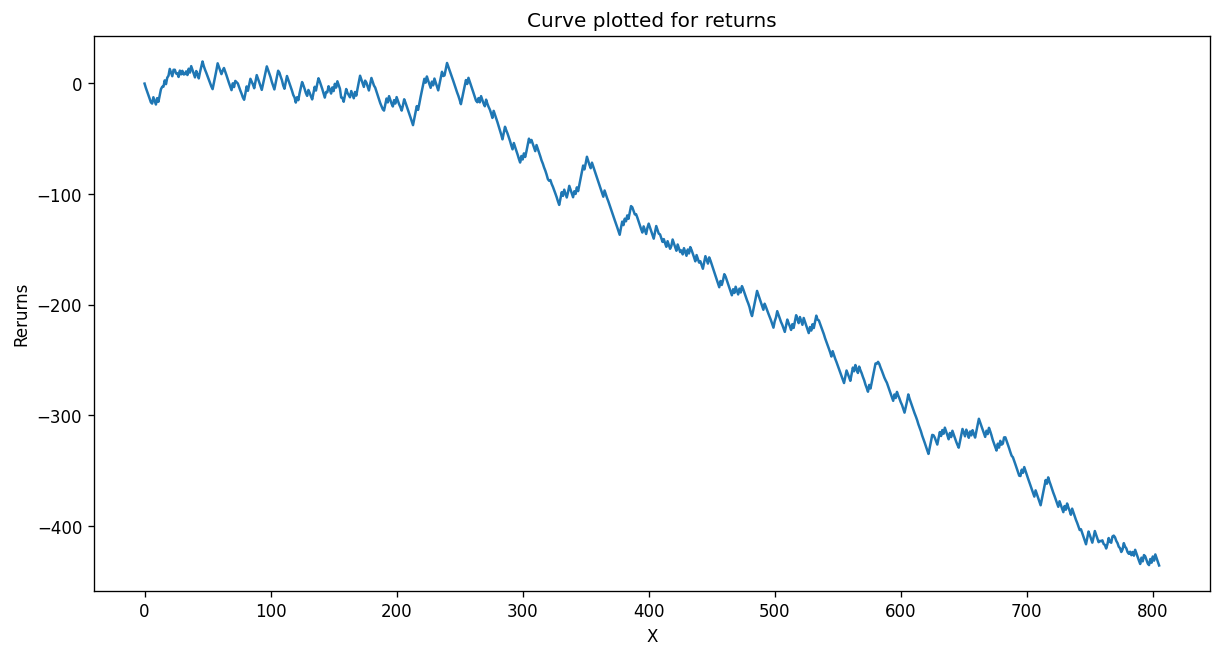

In [21]:
copy_trades = stats['_trades'].copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()